shape of key:  (509,)
shape of trace dataset:  (100, 507, 950)


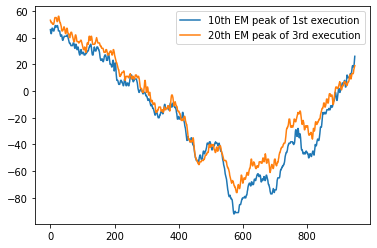

In [1]:
# example of how to load and use the traces

import numpy as np, tqdm, matplotlib.pyplot as plt
from h5py import File

with File("./data/data_1.h5","r") as f_data:
    key = np.array(f_data['key'], dtype='int16') # secret key to be found
    traces = np.array(f_data["traces"], dtype='int8') # EM traces

print("shape of key: ",key.shape)
print("shape of trace dataset: ",traces.shape)

plt.plot(traces[0,9], label="10th EM peak of 1st execution")
plt.plot(traces[2,19], label="20th EM peak of 3rd execution")
plt.legend()
plt.show()

# Attack script

In [15]:
import numpy as np, tqdm, matplotlib.pyplot as plt
from h5py import File
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def cyclic_dot_product(a,b):
    assert(len(a)==len(b))
    return [np.dot(a,np.roll(b,i)) for i in range(len(b))]

def attack(key_numbers, n_at):

    for key_number in key_numbers:
        # time window for locating the -1's, from first leakage assessment
        targeted_window_1 = np.arange(195,250)
        window_size_1 = len(targeted_window_1)

        # time window for locating the 0's, from second leakage assessment
        targeted_window_2 = np.arange(545,580)
        window_size_2 = len(targeted_window_2)
        
        # get the traces
        with File("./data/data_{}.h5".format(key_number),"r") as f_data:
            true_key = np.array(f_data['key'], dtype='int16')
            traces = np.array(f_data["traces"], dtype='int8')

        # do you want to randomly permute the traces and start over?
        # then change the next condition
        if False:
            traces = traces[np.random.permutation(traces.shape[0])]

        # true key used for verification purpose only
        true_key.flags.writeable = False
        
        for n_traces in n_at:

            ########################################################
            ##### First phase of the attack: locating the -1's #####
            ########################################################

            # getting ready for clustering
            # gathering all the peaks to perform the clustering
            X = traces[:n_traces,:,targeted_window_1].reshape((N*n_traces,window_size_1))

            y = KMeans(n_clusters=2,random_state=42).fit(X).labels_
            
            # for a 2-clustering, set label 1 to smallest cluster, that should be the -1's
            bcount = np.bincount(y)
            if bcount[0] < bcount[1]:
                    y = 1-y
            
            y = y.reshape(n_traces,N)

            # choosing a reference vector of labels (minimizing CSR)
            ref_trace_index = 0
            best_ratio = 1
            for i in range(n_traces):
                bc = np.bincount(y[i])
                ratio = np.abs(np.min(bc)/np.max(bc)-0.5)
                if ratio < best_ratio:
                    best_ratio = ratio
                    ref_trace_index = i

            # add two zero's for the missing first and last peaks
            ref_labels = np.concatenate((np.zeros(1,dtype='int'), y[ref_trace_index], np.zeros(1,dtype='int')))

            # accumulator to apply majority vote
            acc_maj_vote = np.zeros((NTRU_N,2), dtype='int')

            kept_indices = [] # traces that we do not discard
            rotation_indices = [] # used to store the guessed rotation indices

            for i in range(n_traces):
                # for each vector of labels, find the best rotation that matches ref_labels

                # add two zero's for the missing first and last peaks
                tmp_y = np.concatenate((np.zeros(1,dtype='int'), y[i], np.zeros(1,dtype='int')))

                # perform the rotations and dot products
                cdp = cyclic_dot_product(ref_labels, tmp_y)

                # get the two maximal values
                maxv = np.sort(cdp)[-2:]

                # discard if the two maximal values are too close (no peak)
                # (threshold that can be changed)
                if maxv[1]-maxv[0] >= 10:
                    # keep this trace
                    kept_indices.append(i)

                    # associated assumed rotation index
                    rotation_indices.append(np.argmax(cdp))

                    # rotate the vector of labels
                    shifted_tmp_y = np.roll(tmp_y, rotation_indices[-1])

                    # update majority vote with shifted labels
                    for j in range(NTRU_N):
                        acc_maj_vote[j, shifted_tmp_y[j]] += 1
            
            # majority vote to discriminate -1 vs 0/1
            guessed_key_m1 = np.argmax(acc_maj_vote, axis=1)

            # indices where the -1 should be
            ind_m1 = np.where(guessed_key_m1 == 1)[0]

            #######################################################
            ##### second part of the attack: locating the 0's #####
            #######################################################

            # indices that are assumed to point to 0 and 1 coefficients: [0,508] - ind_m1
            ind_01 = np.setdiff1d(np.arange(NTRU_N), ind_m1, assume_unique=True)

            # getting the L1 distance of consecutive peaks on the area of interest
            l1_dist_traces = {}

            for c in ind_01:
                l1_dist = []
                for i, ki in enumerate(kept_indices):
                    current_place = (c-rotation_indices[i])%NTRU_N
                    if 507 >= current_place >= 2: # 3 positions for which we don't have diff traces: (0,1,508) / 0 and 508 by choice (difformed peaks), 1 because not possible        
                        current_l1_dist = np.sum(np.abs(traces[ki, current_place-1, targeted_window_2]-traces[ki, current_place-2, targeted_window_2]))
                        l1_dist.append(current_l1_dist)

                # average over the distances for c-th coeff
                # hopefully, one average trace per coefficient
                if len(l1_dist) > 0:
                    l1_dist_traces[c] = np.mean(l1_dist)

            # we're gonna classify according to the average of each trace compared to the global average
            # the classification threshold is the following one:
            mean_l1_dist = np.mean(list(l1_dist_traces.values()))
            
            # calculating the labels
            labels = []
            for c in ind_01:
                
                # if traces are available for c
                if c in l1_dist_traces.keys():
                    m = l1_dist_traces[c]
                    if m < mean_l1_dist:
                        labels.append(0)
                    else:
                        labels.append(1)
                        
                # otherwise choose randomly
                else:
                    labels.append(np.random.choice([0,1]))

            labels = np.array(labels)

            # indices where the 0's and the 1's should be located
            ind_0 = ind_01[np.where(labels==0)[0]]
            ind_1 = ind_01[np.where(labels==1)[0]]

            # building our key candidate
            final_key = np.zeros(NTRU_N, dtype='int')
            final_key[ind_m1] = 2**11-1
            final_key[ind_0] = 0
            final_key[ind_1] = 1

            #######################
            ##### Final check #####
            #######################

            # we might get the right key up to a final global rotation
            # that can be brute forced
            global_rot_ind = np.argmax(cyclic_dot_product(true_key, final_key))
            nb_matching_coeff = np.sum(true_key == np.roll(final_key, global_rot_ind))

            # (brute force correction of wrong coefficients is not implemented)
            
            if nb_matching_coeff == NTRU_N:
                print("Key {} found with {} traces.".format(key_number, n_traces))
                break # done!
    
    print("Done.")

In [14]:
# next parameters should not be modified
NTRU_N = 509
NTRU_LOGQ = 11
NTRU_Q = (1 << NTRU_LOGQ)

N = 507 # number of coeff/peaks extracted (do not change)
dim_traces = 950

# you can tweak the next two parameters
Sk = np.arange(1,21) # set of key indices to test, number of keys up to 200, for full set, write: np.arange(1,201)
n_at = np.arange(20,70,1) # number of attack traces to try, up to 100 per key (np.arange(2,100))

# start attack
attack(Sk, n_at)

Key 1 found with 40 traces.
Key 2 found with 23 traces.
Key 3 found with 57 traces.
Key 4 found with 60 traces.
Key 5 found with 38 traces.
Key 6 found with 28 traces.
Key 7 found with 50 traces.
Key 8 found with 30 traces.
Key 9 found with 49 traces.
Key 10 found with 52 traces.
Key 11 found with 68 traces.
Key 12 found with 28 traces.
Key 13 found with 24 traces.
Key 14 found with 34 traces.
Key 15 found with 37 traces.
Key 16 found with 49 traces.
Key 17 found with 64 traces.
Key 18 found with 41 traces.
Key 19 found with 54 traces.
Key 20 found with 49 traces.
Done.
